* Name: Sandeep Kumar Kushwaha
* Email: sandeepkumar998855@gmail.com
* LinkedIn: https://www.linkedin.com/in/xandie985/

## All you need is love… And a dog!
Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not. You will be working with the following features:

- animal_type: Type of animal. May be one of 'cat', 'dog', 'bird', etc.
- intake_year: Year of intake
- intake_condition: The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
- intake_number: The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
- intake_type: The type of intake, for example, 'stray', 'owner surrender', etc.
- sex_upon_intake: The gender of the animal and if it has been spayed or neutered at the time of intake
- age_upon_intake_(years): The age of the animal upon intake represented in years
- time_in_shelter_days: Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
- sex_upon_outcome: The gender of the animal and if it has been spayed or neutered at time of outcome
- age_upon_outcome_(years): The age of the animal upon outcome represented in years
- outcome_type: The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.


A) Load the dataset and perform the standard steps you would do in any data science project, e.g: data exploration, data cleaning, preprocessing etc. Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 

B) Train a random forest. Use 3-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, the train and test accuracies, and the 10 most important features.

Explain each of your steps and discuss the results.

In [315]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
!pip install imblearn
from imblearn.over_sampling import SMOTE

In [238]:
df = pd.read_csv('aac_intakes_outcomes.csv')

In [239]:
print(df.columns)

Index(['age_upon_outcome', 'animal_id_outcome', 'date_of_birth',
       'outcome_subtype', 'outcome_type', 'sex_upon_outcome',
       'age_upon_outcome_(days)', 'age_upon_outcome_(years)',
       'age_upon_outcome_age_group', 'outcome_datetime', 'outcome_month',
       'outcome_year', 'outcome_monthyear', 'outcome_weekday', 'outcome_hour',
       'outcome_number', 'dob_year', 'dob_month', 'dob_monthyear',
       'age_upon_intake', 'animal_id_intake', 'animal_type', 'breed', 'color',
       'found_location', 'intake_condition', 'intake_type', 'sex_upon_intake',
       'count', 'age_upon_intake_(days)', 'age_upon_intake_(years)',
       'age_upon_intake_age_group', 'intake_datetime', 'intake_month',
       'intake_year', 'intake_monthyear', 'intake_weekday', 'intake_hour',
       'intake_number', 'time_in_shelter', 'time_in_shelter_days'],
      dtype='object')


From the above column headers, we can move forward to deal with the 'outcome_type' as out main target. 

## Considering relevant columns only

In [240]:
relevant_cols = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', 'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', 'outcome_type']
df = df[relevant_cols]
print(tabulate(df.head(), headers=df.columns, tablefmt='psql'))

+----+---------------+---------------+--------------------+-----------------+-----------------+-------------------+---------------------------+------------------------+--------------------+----------------------------+-----------------+
|    | animal_type   |   intake_year | intake_condition   |   intake_number | intake_type     | sex_upon_intake   |   age_upon_intake_(years) |   time_in_shelter_days | sex_upon_outcome   |   age_upon_outcome_(years) | outcome_type    |
|----+---------------+---------------+--------------------+-----------------+-----------------+-------------------+---------------------------+------------------------+--------------------+----------------------------+-----------------|
|  0 | Dog           |          2017 | Normal             |               1 | Stray           | Neutered Male     |                        10 |               0.588194 | Neutered Male      |                         10 | Return to Owner |
|  1 | Dog           |          2014 | Normal       

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79672 entries, 0 to 79671
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   animal_type               79672 non-null  object 
 1   intake_year               79672 non-null  int64  
 2   intake_condition          79672 non-null  object 
 3   intake_number             79672 non-null  float64
 4   intake_type               79672 non-null  object 
 5   sex_upon_intake           79671 non-null  object 
 6   age_upon_intake_(years)   79672 non-null  float64
 7   time_in_shelter_days      79672 non-null  float64
 8   sex_upon_outcome          79671 non-null  object 
 9   age_upon_outcome_(years)  79672 non-null  float64
 10  outcome_type              79662 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 6.7+ MB


In [242]:
df.isna().sum()

animal_type                  0
intake_year                  0
intake_condition             0
intake_number                0
intake_type                  0
sex_upon_intake              1
age_upon_intake_(years)      0
time_in_shelter_days         0
sex_upon_outcome             1
age_upon_outcome_(years)     0
outcome_type                10
dtype: int64

In [243]:
df.dropna(inplace=True)
df.isna().values.any()

False

## Checking target column

In [244]:
df.outcome_type.value_counts()

Adoption           33594
Transfer           23799
Return to Owner    14790
Euthanasia          6244
Died                 690
Disposal             304
Rto-Adopt            179
Missing               46
Relocate              15
Name: outcome_type, dtype: int64

We observe, *Adoption*, *Transfer*, *Return to Owner*, *Euthanasia* are most prominent features. 
But since we only need to predict whether animal was Adopted or not. We can perform binary classification for now. 

In [245]:
df['outcome_type'] = df['outcome_type'].map(lambda x: 1 if x == 'Adoption' else 0)


## Feature Engineering

Converting data to feed the random forest.  

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79661 entries, 0 to 79671
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   animal_type               79661 non-null  object 
 1   intake_year               79661 non-null  int64  
 2   intake_condition          79661 non-null  object 
 3   intake_number             79661 non-null  float64
 4   intake_type               79661 non-null  object 
 5   sex_upon_intake           79661 non-null  object 
 6   age_upon_intake_(years)   79661 non-null  float64
 7   time_in_shelter_days      79661 non-null  float64
 8   sex_upon_outcome          79661 non-null  object 
 9   age_upon_outcome_(years)  79661 non-null  float64
 10  outcome_type              79661 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 7.3+ MB


### animal_type

In [247]:
df.animal_type.value_counts()

Dog      45363
Cat      29536
Other     4423
Bird       339
Name: animal_type, dtype: int64

In [248]:
#performing OHE on animal_type
df = pd.get_dummies(df, columns=['animal_type'])

### intake_year

In [249]:
df.intake_year.value_counts()

2015    18699
2014    18641
2016    17630
2017    17436
2013     4177
2018     3078
Name: intake_year, dtype: int64

### intake_condition             

In [250]:
df.intake_condition.value_counts()

Normal      70046
Injured      3997
Sick         3098
Nursing      1915
Aged          319
Other         147
Feral          92
Pregnant       47
Name: intake_condition, dtype: int64

In [251]:
#performing OHE on intake_condition
df = pd.get_dummies(df, columns=['intake_condition'])

 ### intake_number

In [252]:
df.intake_number.value_counts()

1.0     71986
2.0      6048
3.0      1152
4.0       302
5.0       101
6.0        39
7.0        15
8.0         7
10.0        3
11.0        3
9.0         3
12.0        1
13.0        1
Name: intake_number, dtype: int64

In [253]:
# IGNORING AS RESULTS WERE NOT GOOD
# since this is important column, we divide the data into bins
# bins = [0, 1, 3, 8, float('inf')]
# labels = ['1', '2-3', '4-8', '8+']
# df['intake_number_group'] = pd.cut(df['intake_number'], bins=bins, labels=labels)

# replacement_mapping = {'1': 1, '2-3': 2, '4-8': 3, '8+': 4}
# df['intake_number_group'] = df['intake_number_group'].replace(replacement_mapping)

# df = df.drop('intake_number', axis=1)


### intake_type

In [254]:
df.intake_type.value_counts()

Stray                 55932
Owner Surrender       15027
Public Assist          4992
Wildlife               3459
Euthanasia Request      251
Name: intake_type, dtype: int64

In [255]:
#performing OHE on intake_type
df = pd.get_dummies(df, columns=['intake_type'])

### sex_upon_intake

In [256]:
df.sex_upon_intake.value_counts()

Intact Male      25315
Intact Female    23702
Neutered Male    12707
Spayed Female    11153
Unknown           6784
Name: sex_upon_intake, dtype: int64

In [257]:
#performing OHE on sex_upon_intake
df = pd.get_dummies(df, columns=['sex_upon_intake'])

### age_upon_intake_(years)

In [258]:
df['age_upon_intake_(years)'].value_counts()

1.000000     14577
2.000000     11529
0.082192      7457
3.000000      5206
0.164384      4023
4.000000      3071
0.076712      2816
5.000000      2736
0.057534      2276
0.328767      2047
0.410959      2005
0.246575      1936
6.000000      1848
0.038356      1596
7.000000      1573
0.493151      1538
8.000000      1521
0.019178      1194
0.739726      1191
10.000000     1152
0.575342      1151
0.657534       897
9.000000       865
0.821918       713
12.000000      591
0.904110       524
0.000000       449
11.000000      449
13.000000      379
0.008219       347
0.002740       345
0.005479       271
14.000000      249
15.000000      214
0.095890       201
0.016438       190
0.010959       186
0.013699       125
16.000000      106
17.000000       59
18.000000       27
19.000000       13
20.000000       13
22.000000        4
25.000000        1
Name: age_upon_intake_(years), dtype: int64

In [259]:
# IGNORING AS RESULTS WERE NOT GOOD
# bins = [0, 1, 5, 10, 20, float('inf')]
# labels = ['<1', '1-5', '5-10', '10-20', '20+']
# df['age_group'] = pd.cut(df['age_upon_intake_(years)'], bins=bins, labels=labels)

# replacement_mapping = {'<1': 0, '1-5': 1, '5-10': 2, '10-20': 3, '20+':4}
# df['age_group'] = df['age_group'].replace(replacement_mapping)

# df = df.drop('age_upon_intake_(years)', axis=1)

### time_in_shelter_days

In [260]:
df.time_in_shelter_days.value_counts()

0.004167      77
0.008333      77
0.007639      77
0.009722      77
0.011806      77
              ..
16.802083      1
15.568750      1
101.061111     1
12.622917      1
2.885417       1
Name: time_in_shelter_days, Length: 29315, dtype: int64

### sex_upon_outcome

In [261]:
df.sex_upon_outcome.value_counts()

Neutered Male    28292
Spayed Female    25549
Intact Male       9730
Intact Female     9306
Unknown           6784
Name: sex_upon_outcome, dtype: int64

In [262]:
#performing OHE on sex_upon_outcome
df = pd.get_dummies(df, columns=['sex_upon_outcome'])

### age_upon_outcome_(years)

In [263]:
df['age_upon_outcome_(years)'].value_counts()

1.000000     14747
2.000000     11542
0.164384      9246
3.000000      5277
0.246575      3401
0.082192      3393
4.000000      3044
5.000000      2747
0.328767      2417
0.410959      1955
0.493151      1905
6.000000      1850
8.000000      1588
7.000000      1572
0.057534      1474
0.038356      1340
0.821918      1237
0.076712      1204
0.657534      1201
10.000000     1191
0.575342       986
0.019178       953
9.000000       839
0.739726       705
12.000000      613
0.904110       512
11.000000      444
13.000000      399
14.000000      255
0.008219       238
0.005479       226
15.000000      214
0.002740       157
0.016438       152
0.010959       136
0.013699       116
16.000000      107
0.000000        93
0.095890        67
17.000000       59
18.000000       28
19.000000       13
20.000000       13
22.000000        4
25.000000        1
Name: age_upon_outcome_(years), dtype: int64

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79661 entries, 0 to 79671
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   intake_year                     79661 non-null  int64  
 1   intake_number                   79661 non-null  float64
 2   age_upon_intake_(years)         79661 non-null  float64
 3   time_in_shelter_days            79661 non-null  float64
 4   age_upon_outcome_(years)        79661 non-null  float64
 5   outcome_type                    79661 non-null  int64  
 6   animal_type_Bird                79661 non-null  uint8  
 7   animal_type_Cat                 79661 non-null  uint8  
 8   animal_type_Dog                 79661 non-null  uint8  
 9   animal_type_Other               79661 non-null  uint8  
 10  intake_condition_Aged           79661 non-null  uint8  
 11  intake_condition_Feral          79661 non-null  uint8  
 12  intake_condition_Injured        

## Splitting data into train test

Regular split

In [266]:
X = df.drop('outcome_type', axis=1)  # Select all columns except 'outcome_type'
y = df['outcome_type']  # Select 'outcome_type' as the target

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(len(X_train), len(y_train),len(X_test), len(y_test))

63728 63728 15933 15933


In [270]:
print('Checking the regular split class distribution','\n', pd.Series(y_train).value_counts()) 

Checking the regular split class distribution 
 0    36864
1    26864
Name: outcome_type, dtype: int64


SMOTE split

In [277]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

print('Checking the smote split class distribution','\n',pd.Series(y_train_resampled).value_counts()) 

Checking the smote split class distribution 
 1    36864
0    36864
Name: outcome_type, dtype: int64


### Training Random Forest Classifier

In [317]:
# Create an instance of the random forest classifier:
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth':[0,5,10,15,20, 25]
}


Modelling with regular split

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\ProgramData\Anaconda3\lib\site-packages\jobl

Best Parameters: {'max_depth': 15, 'n_estimators': 200}
Best Score: 0.8554168098653081
Test Accuracy: 0.8454151760497082
Report:  
               precision    recall  f1-score   support

           0       0.92      0.81      0.86      9203
           1       0.77      0.90      0.83      6730

    accuracy                           0.85     15933
   macro avg       0.84      0.85      0.84     15933
weighted avg       0.86      0.85      0.85     15933



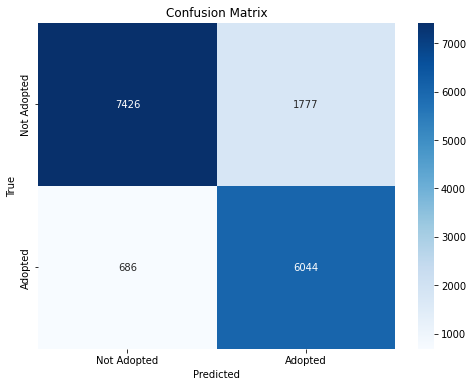

Top 10 Features with :
time_in_shelter_days : 0.30963664206942443
sex_upon_outcome_Intact Male : 0.09474525823913116
sex_upon_outcome_Intact Female : 0.07173297585831309
age_upon_outcome_(years) : 0.06652250873356805
sex_upon_outcome_Spayed Female : 0.06610308322003759
sex_upon_outcome_Neutered Male : 0.04462966356728505
age_upon_intake_(years) : 0.04407621868204077
intake_type_Owner Surrender : 0.04287669330104161
sex_upon_intake_Intact Male : 0.039592691081550634
intake_type_Public Assist : 0.03632010935281994


In [318]:
#Perform grid search with 3-fold cross-validation:
grid_search_reg = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)
grid_search_reg.fit(X_train, y_train)

# best parameters
print("Best Parameters:", grid_search_reg.best_params_)
print("Best Score:", grid_search_reg.best_score_)
best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']

# Fit the random forest with the best parameters
best_classifier = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=42)
best_classifier.fit(X_train, y_train)

# Evaluate the model on the test set:
y_pred = best_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print('Report: ', '\n', report)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Define class labels
class_labels = ['Not Adopted', 'Adopted']
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# important features
importances = best_classifier.feature_importances_
feature_names = X_train.columns
feature_importances = list(zip(feature_names, importances))
sorted_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
top_10_features = sorted_importances[:10]
print("Top 10 Features with :")
for feature, importance in top_10_features:
    print(feature, ":", importance)

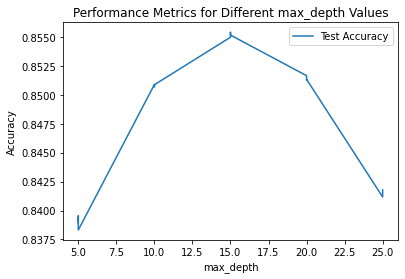

In [319]:
# Collect the performance metrics for each depth value
depth_values = []
test_scores = []

for params, mean_test_score in zip(grid_search_reg.cv_results_['params'],
                                                     grid_search_reg.cv_results_['mean_test_score']):
    depth_values.append(params['max_depth'])
    test_scores.append(mean_test_score)

# Plot the results
plt.plot(depth_values, test_scores, label='Test Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Performance Metrics for Different max_depth Values')
plt.legend()
plt.show()

Modelling with SMOTE split

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\ProgramData\Anaconda3\lib\site-packages\jobl

Best Parameters: {'max_depth': 20, 'n_estimators': 300}
Best Score: 0.8678927951388888
Test Accuracy: 0.8503734387748698
Report:  
               precision    recall  f1-score   support

           0       0.93      0.80      0.86      9203
           1       0.77      0.91      0.84      6730

    accuracy                           0.85     15933
   macro avg       0.85      0.86      0.85     15933
weighted avg       0.86      0.85      0.85     15933



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


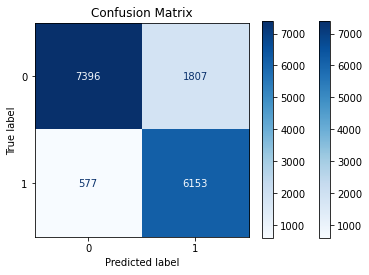

Top 10 Features with :
time_in_shelter_days : 0.3597320903161585
age_upon_outcome_(years) : 0.07599362450247833
sex_upon_outcome_Intact Male : 0.07204862893649586
age_upon_intake_(years) : 0.06388936831869803
sex_upon_outcome_Intact Female : 0.05794198411733437
sex_upon_outcome_Spayed Female : 0.03997281935716317
intake_type_Public Assist : 0.03780703398689643
intake_type_Owner Surrender : 0.03581661649100576
sex_upon_outcome_Neutered Male : 0.03294133588177573
intake_year : 0.03130696943699249


In [320]:
#Perform grid search with 3-fold cross-validation:
grid_search_SMOTE = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)
grid_search_SMOTE.fit(X_train_resampled, y_train_resampled)

print("Best Parameters:", grid_search_SMOTE.best_params_)
print("Best Score:", grid_search_SMOTE.best_score_)

# Evaluate the model on the test set:
y_pred = grid_search_SMOTE.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print('Report: ', '\n', report)

# Plot the confusion matrix
disp = plot_confusion_matrix(grid_search_SMOTE, X_test, y_test, cmap=plt.cm.Blues, normalize=None);
disp.ax_.set_title("Confusion Matrix")
# Add colorbar
plt.colorbar(disp.im_, ax=disp.ax_)
# Show the plot
plt.show()


# important features
importances = grid_search_SMOTE.best_estimator_.feature_importances_
feature_names = X_train_resampled.columns
feature_importances = list(zip(feature_names, importances))
sorted_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
top_10_features = sorted_importances[:10]
print("Top 10 Features with :")
for feature, importance in top_10_features:
    print(feature, ":", importance)


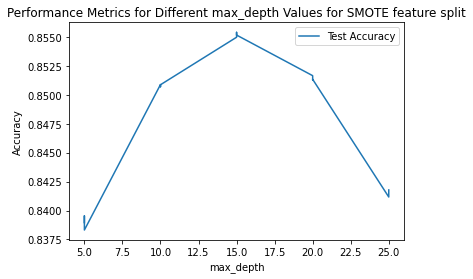

In [321]:
# Collect the performance metrics for each depth value
depth_values = []
test_scores = []

for params, mean_test_score in zip(grid_search_SMOTE.cv_results_['params'],
                                                     grid_search_reg.cv_results_['mean_test_score']):
    depth_values.append(params['max_depth'])
    test_scores.append(mean_test_score)

# Plot the results
plt.plot(depth_values, test_scores, label='Test Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Performance Metrics for Different max_depth Values for SMOTE feature split')
plt.legend()
plt.show()

#### *Observations for regular split*

* Best Score: The best mean cross-validated score achieved during the grid search is 0.8678927951388888 on the training set.

* Test Accuracy: The accuracy of the model on the test set is 0.8503734387748698, which suggests the model has generalizes well to unseen data.

* Classification Report: The classification report provides precision, recall, and F1-score for each class (0 and 1) along with the support (number of samples) for each class. It gives an overview of the model's performance in terms of different metrics.

* Top 10 Features: The list of top 10 important features and their corresponding importances is provided. These features indicate which variables have the most influence on the model's predictions. For example, time_in_shelter_days is the most important feature with an importance of 0.3597320903161585.